# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [1]:
from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.plots.plots import *
from debruiteur.preprocessing.preprocessor import *
from debruiteur.noise.noise import *
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import *
from debruiteur.statistics.statistics import * 
from debruiteur.metrics.metrics import *

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=10),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(freq=0.3),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \dot \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

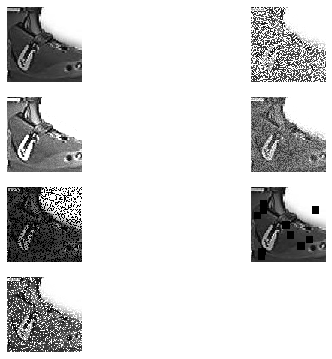

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,13142.9128,0.844261,6.943887,0.250398
1,PoissonNoise,3238.7504,0.419102,13.027029,0.638872
2,UniformNoise,2523.0359,0.369907,14.111569,0.433984
3,SaltPepperNoise,5586.2724,0.550417,10.659583,0.271269
4,SquareMaskNoise,922.1846,0.223635,18.482625,0.864763
5,SpeckleNoise,5441.5218,0.543239,10.773600,0.368908


In [4]:
metrics_example(df_noised, noise_class_list)

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [6]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods

In [7]:
noise_reduction_methods = [('Wiener Filter', lambda img: wiener_filter(img * 255)),
                   ('Laplacian Filter', lambda img: laplacian_filter(img * 255)),
                   ('Gaussian Weighted Filter', lambda img: gaussian_weighted_substract_filter(img * 255)),
                   ('Mean Filter', lambda img: mean_filter(img * 255)),
                   ('Median Filter', lambda img: median_filter(img * 255)),
                   ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                   ('FFT FIlter', lambda img: fft_filter(img * 255)),
                   ('Convolutional Autoencoder', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                   ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),
                   ('Generative Adversarial Network', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255)]

### Noise reduction methods metrics averaged on all kind of noises

In [8]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

C:\Users\jonas.freiburg\Documents\Niveau3\imagerie\traitement_image\projet\ledebruiteur\debruiteur\metrics\metrics.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr = metrics.peak_signal_noise_ratio(orignal_img, transformed_img)
C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,MSE,NRMSE,PSNR,SSIM
Wiener Filter,4.333780e-01,1.298155e+00,3.700766,0.279901
Laplacian Filter,2.133707e+04,2.750476e+02,-42.621292,0.000132
Gaussian Weighted Filter,2.912425e+04,3.289086e+02,-44.309491,0.000172
Mean Filter,2.145967e+04,2.759374e+02,-42.653091,0.000214
Median Filter,2.328902e+04,2.909791e+02,-43.232203,0.000445
Conservative Filter,2.469657e+04,2.999938e+02,-43.465212,0.000311
FFT FIlter,6.218417e+13,1.505897e+07,-137.482788,0.000064
Convolutional Autoencoder,1.193743e+04,1.906208e+02,-38.411387,0.000733
Dense Autoencoder,1.685274e+04,2.547397e+02,-42.254920,0.000079
Generative Adversarial Network,1.362280e+04,2.135246e+02,-40.192132,0.000750


### Noise reductions methods for each noise type

C:\Users\jonas.freiburg\Documents\Niveau3\imagerie\traitement_image\projet\ledebruiteur\debruiteur\metrics\metrics.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr = metrics.peak_signal_noise_ratio(orignal_img, transformed_img)
C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)



Compute finish for Wiener Filter



Compute finish for Laplacian Filter



Compute finish for Gaussian Weighted Filter



Compute finish for Mean Filter



Compute finish for Median Filter



Compute finish for Conservative Filter



Compute finish for FFT FIlter



Compute finish for Convolutional Autoencoder



Compute finish for Dense Autoencoder


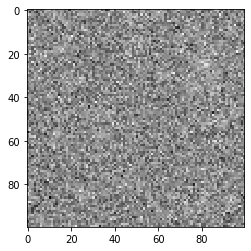

In [9]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")


Compute finish for Wiener Filter



Compute finish for Laplacian Filter



Compute finish for Gaussian Weighted Filter



Compute finish for Mean Filter



Compute finish for Median Filter



Compute finish for Conservative Filter



Compute finish for FFT FIlter



Compute finish for Convolutional Autoencoder



Compute finish for Dense Autoencoder


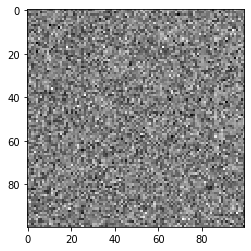

In [10]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")


Compute finish for Wiener Filter



Compute finish for Laplacian Filter



Compute finish for Gaussian Weighted Filter



Compute finish for Mean Filter



Compute finish for Median Filter



Compute finish for Conservative Filter



Compute finish for FFT FIlter



Compute finish for Convolutional Autoencoder



Compute finish for Dense Autoencoder


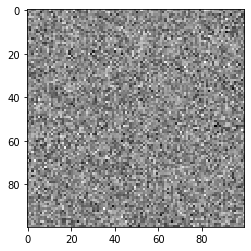

In [11]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")


Compute finish for Wiener Filter



Compute finish for Laplacian Filter



Compute finish for Gaussian Weighted Filter



Compute finish for Mean Filter



Compute finish for Median Filter



Compute finish for Conservative Filter



Compute finish for FFT FIlter



Compute finish for Convolutional Autoencoder



Compute finish for Dense Autoencoder


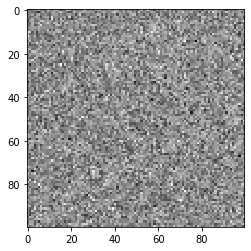

In [12]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")